In [1]:
import numpy as np
import sys
import os
import glob
import getpass
import argparse
import pickle
import matplotlib.cm as cm
import pandas as pd
import matplotlib.pyplot as plt
import collections 
def makehash():
    return collections.defaultdict(makehash)
import fnmatch 
import torch 
from tqdm import tqdm 
from utils import save_dir, analyze_dir, results_dir,train_pool
import scipy.spatial.distance as dist
from tqdm import tqdm
import re
from sklearn.manifold import TSNE


def moving_average(x,w):
    w_min=1#int(np.floor(w/2))
    return pd.Series(x).rolling(w, min_periods=w_min).mean()
av_window=10

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [2]:
x=np.random.rand(32,64)
print(x.shape)
x.mean(axis=0).shape


(32, 64)


(64,)

In [3]:
model_identifier = 'NN-tree_nclass=64_nobj=64000_nhier=6_beta=0.000161_sigma=5.0_nfeat=936-train_test-fixed'
train_identifier = 'epochs-10_batch-32_lr-0.01_momentum-0.5_init-gaussian_std-1e-06'
analyze_identifier='mftma-exm_per_class=50-proj=False-rand=True-kappa=1e-08-n_t=300-n_rep=5'
#epochs-10_batch-32_lr-0.001_momentum-0.5_init-gaussian_std-0.0001
#                           epochs-10_batch-32_lr-0.002_momentum-0.6_init-gaussian_std-1e-05 \
#                           epochs-10_batch-32_lr-0.01_momentum-0.5_init-gaussian_std-1e-06 

In [4]:
# load training data 
training_files=[]
for file in os.listdir(os.path.join(save_dir,model_identifier,train_identifier)):
    if fnmatch.fnmatch(file, '*.pth'):
            training_files.append(os.path.join(save_dir,model_identifier,train_identifier,file))

In [6]:
grad_pkl_files = []
for file in os.listdir(os.path.join(save_dir,analyze_identifier,model_identifier,train_identifier)):
    if fnmatch.fnmatch(file, '*gradient_data_v3.pkl'):
        grad_pkl_files.append(os.path.join(save_dir,analyze_identifier,model_identifier,train_identifier,file))
s = [re.findall('/\d+', x) for x in grad_pkl_files]
s = [item for sublist in s for item in sublist]
dummy_id = [(x.split('/')) for x in s]
file_id = [int(x.split('/')[1]) for x in s]
sorted_files = [grad_pkl_files[x] for x in np.argsort(file_id)]
grad_pkl_files=sorted_files

## Hierarchical accuracies

In [7]:
hier_accu=[]
test_predictions=[]
test_probabilites=[]
test_grad_dict=[]
for idx, files in tqdm(enumerate(training_files)):
    test=torch.load(files)
    hier_accu.append([test['epoch'],test['batchidx'], test['hier_test_acc']])
    test_predictions.append([test['target_test'], test['pred_test']])
    test_probabilites.append( test['pred_test_prob'])
    test_grad_dict.append(test['grad_dict'])
    
dummy=[]
epochs=[]
batches=[]
for item in hier_accu:
    epochs.append(item[0])
    batches.append(item[1])
    dummy.append(item[0]*10000+item[1])
fixed_idx=np.argsort(dummy)

1060it [00:16, 62.96it/s]


In [8]:
epoch_factor=1e3*np.ceil(np.max(batches)/1e3)
epoch_batch=epoch_factor*np.asarray(epochs)+np.asarray(batches)
x_bar= np.arange(len(epoch_batch))/len(epoch_batch)
epoch_bar=np.argwhere(np.diff(np.asarray(epochs)))/(len(epoch_batch))
epoch_bar

array([[0.0990566],
       [0.1990566],
       [0.2990566],
       [0.3990566],
       [0.4990566],
       [0.5990566],
       [0.6990566],
       [0.7990566],
       [0.8990566]])

In [9]:
params = train_pool[model_identifier]()
params.load_dataset()

ERROR:root:ERROR: not a MATLAB datatype: <HDF5 dataset "data": shape (128252,), type "|u1">, (uint8)
ERROR:root:ERROR: not a MATLAB datatype: <HDF5 dataset "ir": shape (128252,), type "<u8">, (uint64)
ERROR:root:ERROR: not a MATLAB datatype: <HDF5 dataset "jc": shape (64128,), type "<u8">, (uint64)
ERROR:root:ERROR: MATLAB type not supported: graph, (uint32)
ERROR:root:ERROR: MATLAB type not supported: graph, (uint32)


In [10]:
gradient_pool_files=[]
for file in os.listdir(os.path.join(save_dir,analyze_identifier,model_identifier,train_identifier)):
    if fnmatch.fnmatch(file, '*_gradient_pooled_v3_large.pkl'):
            gradient_pool_files.append(os.path.join(save_dir,analyze_identifier,model_identifier,train_identifier,file))

In [11]:
params = train_pool[model_identifier]()

In [12]:

gradient_results=pickle.load(open(gradient_pool_files[0],'rb'))
gradient_results_L1=gradient_results['gradient_results']


gradient_results=pickle.load(open(gradient_pool_files[1],'rb'))
gradient_results_L2=gradient_results['gradient_results']


gradient_results=pickle.load(open(gradient_pool_files[2],'rb'))
gradient_results_L3=gradient_results['gradient_results']


hier_keys=list(gradient_results_L1.keys())
all_grads=[gradient_results_L1,gradient_results_L2,gradient_results_L3]

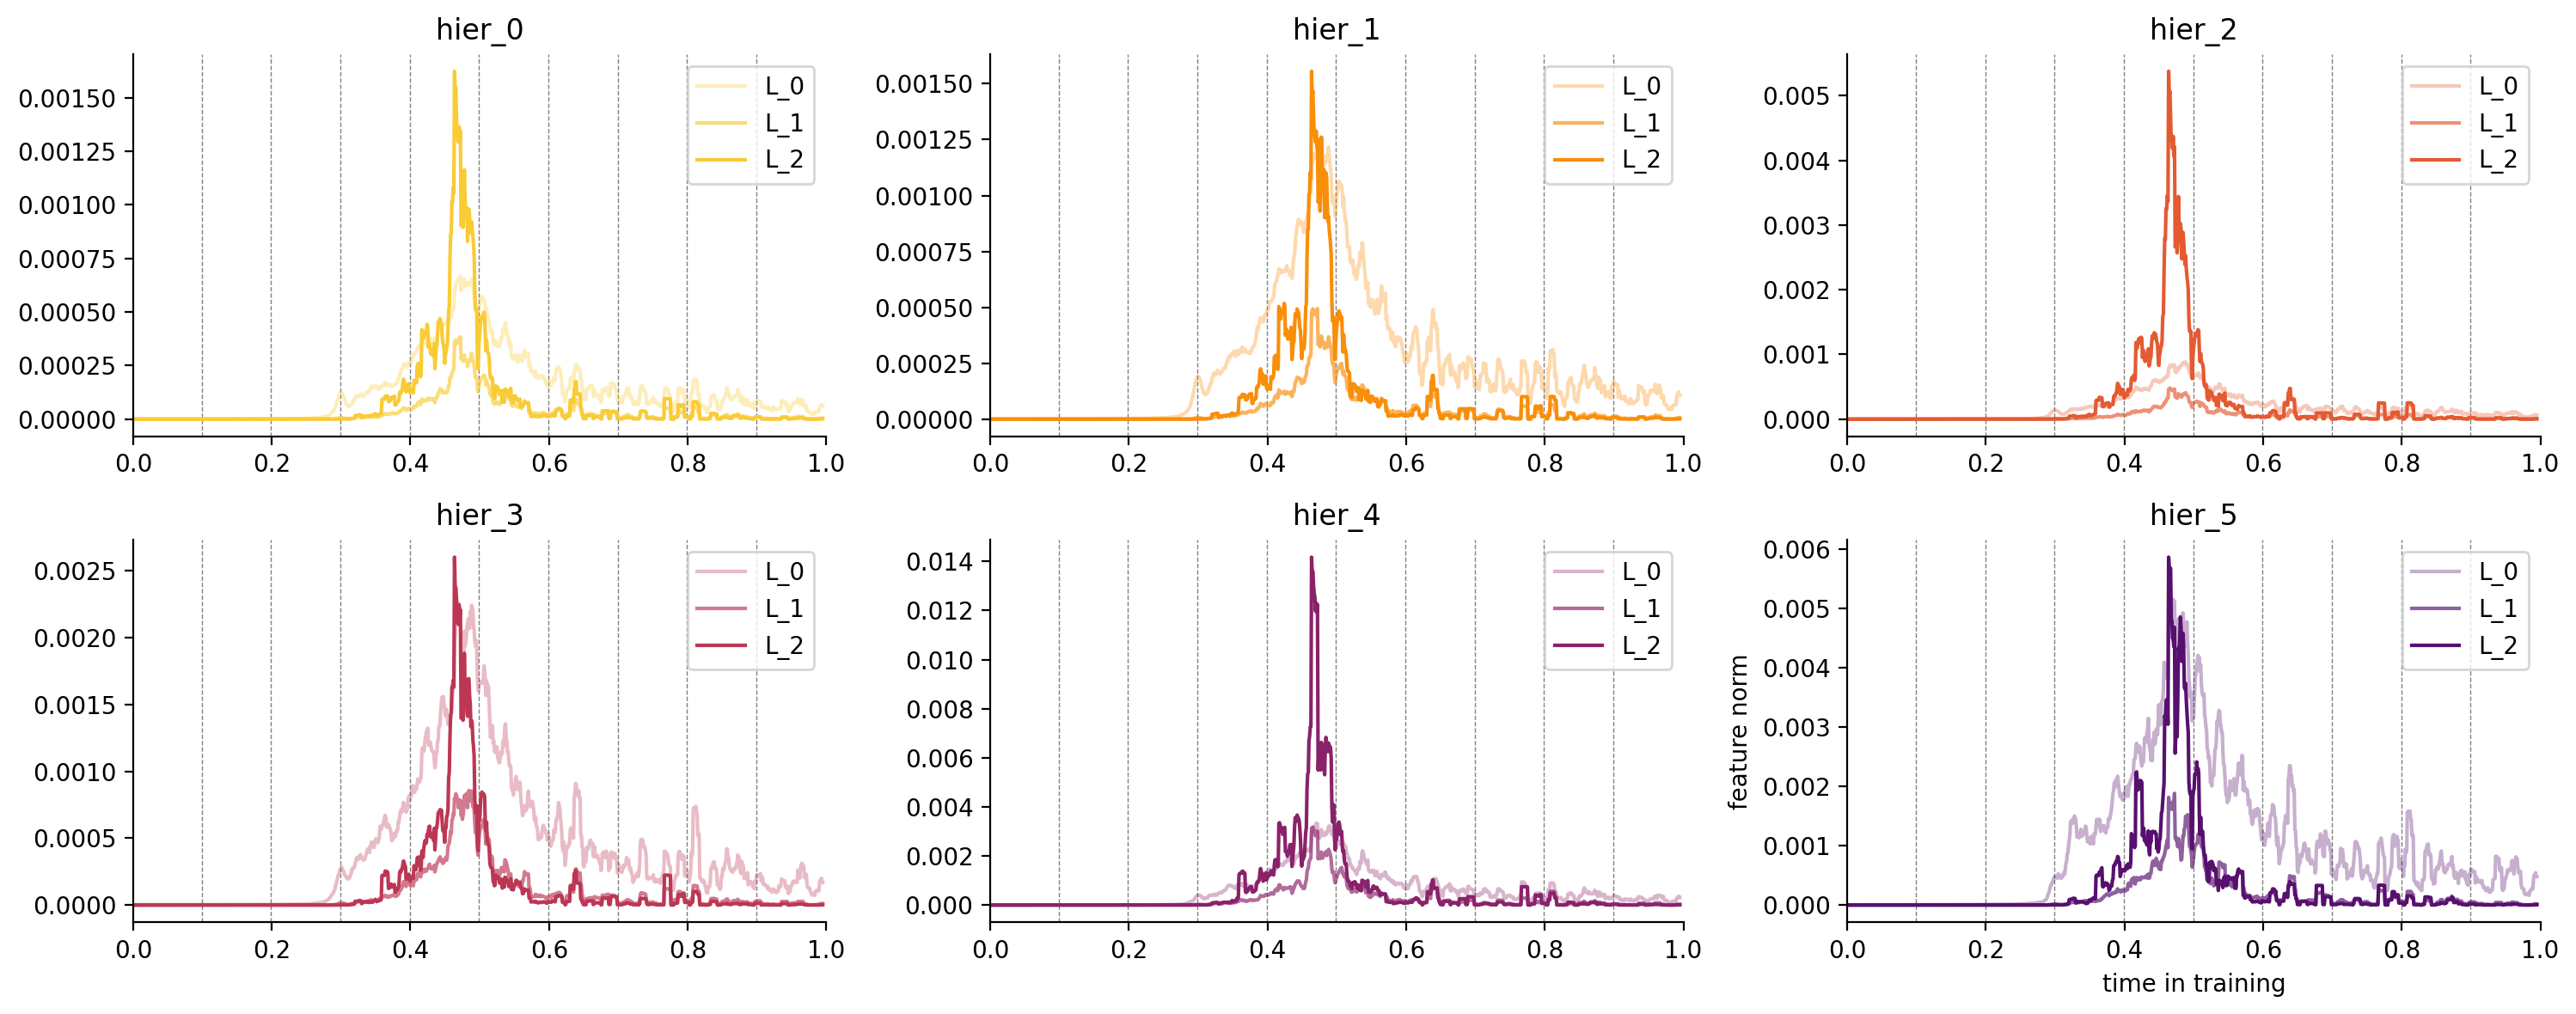

In [15]:
xmin=0
xmax=1
av_window=10
feat_size=[624,208,64]

xmin=0
xmax=1
xtick=np.arange(0,12,2)/10
num_colors=6+1
color_fact=num_colors+2
h0=cm.get_cmap('inferno',color_fact)
line_cols=np.flipud(h0(np.arange(color_fact)/color_fact))
line_cols=line_cols[1:,:]

fig=plt.figure(1,figsize=(15,6),dpi=200,frameon=True)
for idx, hier in enumerate(hier_keys):
    ax1=plt.subplot(2,3,idx+1)
    #ax1=plt.subplot(2,3,1)
    hier_res=[x[hier] for x in all_grads]
    for idy,res in enumerate(hier_res):
        ax1.plot(moving_average(x_bar,av_window),moving_average(np.mean(res,axis=1)/np.sqrt(feat_size[idy]),av_window),label=f"L_{idy}",color=line_cols[idx,:],linewidth=1.5,alpha=(idy+1)/3)
    ax1.legend()
    ax1.set_title(hier)
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    
    ax1.vlines(epoch_bar,ax1.get_ylim()[0],ax1.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
    ax1.autoscale(enable=True, axis='x', tight=True)
    ax1.autoscale(enable=True, axis='y', tight=True)
    ax1.set_xlim((xmin,xmax))



ax1.set_ylabel('feature norm')
ax1.set_xlabel('time in training')
#ax1=plt.subplot(2,3,(7,8)
plt.tight_layout()

fig.savefig(os.path.join(results_dir,model_identifier+'_pairwise_gradient_hierarchy_large.pdf'),transparent=True)


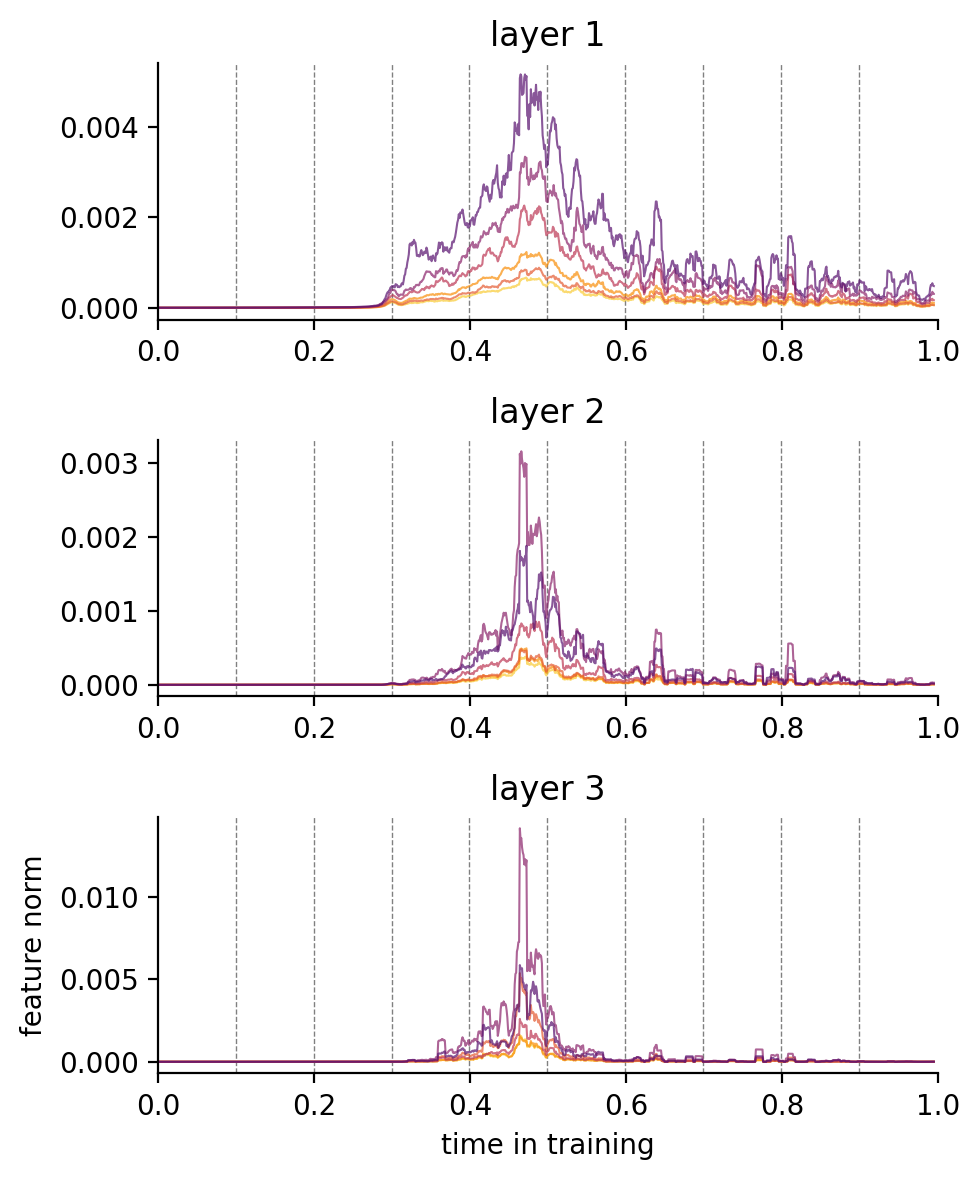

In [14]:
xmin=0
xmax=1
av_window=10
fig=plt.figure(1,figsize=(5,6),dpi=200,frameon=False)
for idx, layer_res in enumerate(all_grads):
    ax1=plt.subplot(3,1,idx+1)
    #ax1=plt.subplot(2,3,1)

    for idy,hier_keu in enumerate(layer_res):
        res=layer_res[hier_keu]
        ax1.plot(moving_average(x_bar,av_window),moving_average(np.mean(res,axis=1)/np.sqrt(feat_size[idx]),av_window),label=f"H_{idy}",color=line_cols[idy,:],linewidth=.75,alpha=.7)
    #ax1.legend()
    ax1.set_title(f"layer {idx+1}")
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    
    ax1.vlines(epoch_bar,ax1.get_ylim()[0],ax1.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
    ax1.autoscale(enable=True, axis='x', tight=True)
    ax1.autoscale(enable=True, axis='y', tight=True)
    ax1.set_xlim((xmin,xmax))



ax1.set_ylabel('feature norm')
ax1.set_xlabel('time in training')


#ax1=plt.subplot(2,3,(7,8)
plt.tight_layout()
fig.savefig(os.path.join(results_dir,model_identifier+'_pairwise_gradient_layer_large.pdf'),transparent=True)

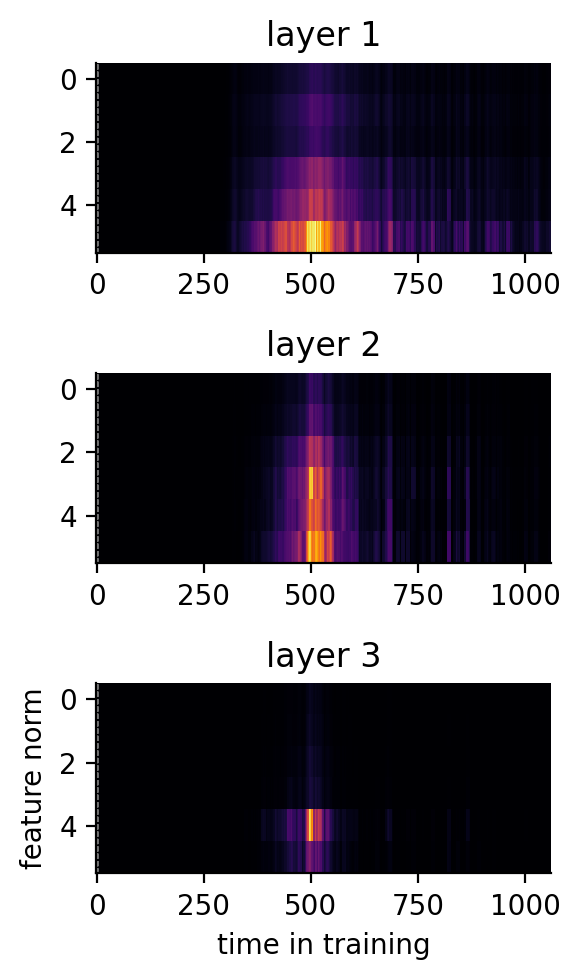

In [62]:
xmin=0
xmax=1
av_window=10
fig=plt.figure(1,figsize=(3,5),dpi=200,frameon=False)
for idx, layer_res in enumerate(all_grads):
    ax1=plt.subplot(3,1,idx+1)
    #ax1=plt.subplot(2,3,1)
    hier_all=[]
    for idy,hier_keu in enumerate(layer_res):
        res=layer_res[hier_keu]
        hier_all.append(moving_average(np.mean(res,axis=1)/np.sqrt(feat_size[idx]),av_window))
    ax1.imshow(np.stack(hier_all),aspect='auto',interpolation='None',cmap='inferno')
    #ax1.legend()
    
    ax1.set_title(f"layer {idx+1}")
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    
    ax1.vlines(epoch_bar,ax1.get_ylim()[0],ax1.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
    ax1.autoscale(enable=True, axis='x', tight=True)
    ax1.autoscale(enable=True, axis='y', tight=True)
    #ax1.set_xlim((xmin,xmax))



ax1.set_ylabel('feature norm')
ax1.set_xlabel('time in training')
#ax1=plt.subplot(2,3,(7,8)
plt.tight_layout()
#fig.savefig(os.path.join(results_dir,model_identifier+'_pairwise_gradient_layer.pdf'),transparent=True)

# compute the average gradients 

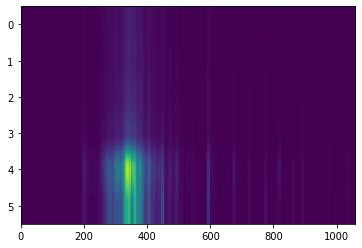

In [41]:

plt.imshow(np.stack(hier_all),aspect='auto')

In [73]:
np.stack(training_l2)

(6, 1060)

['layer_1_Linear', 'layer_2_Linear', 'layer_3_Linear']

In [26]:
np.mean(np.linalg.norm(layer_res[1][1],axis=1))

2.5066996e-08

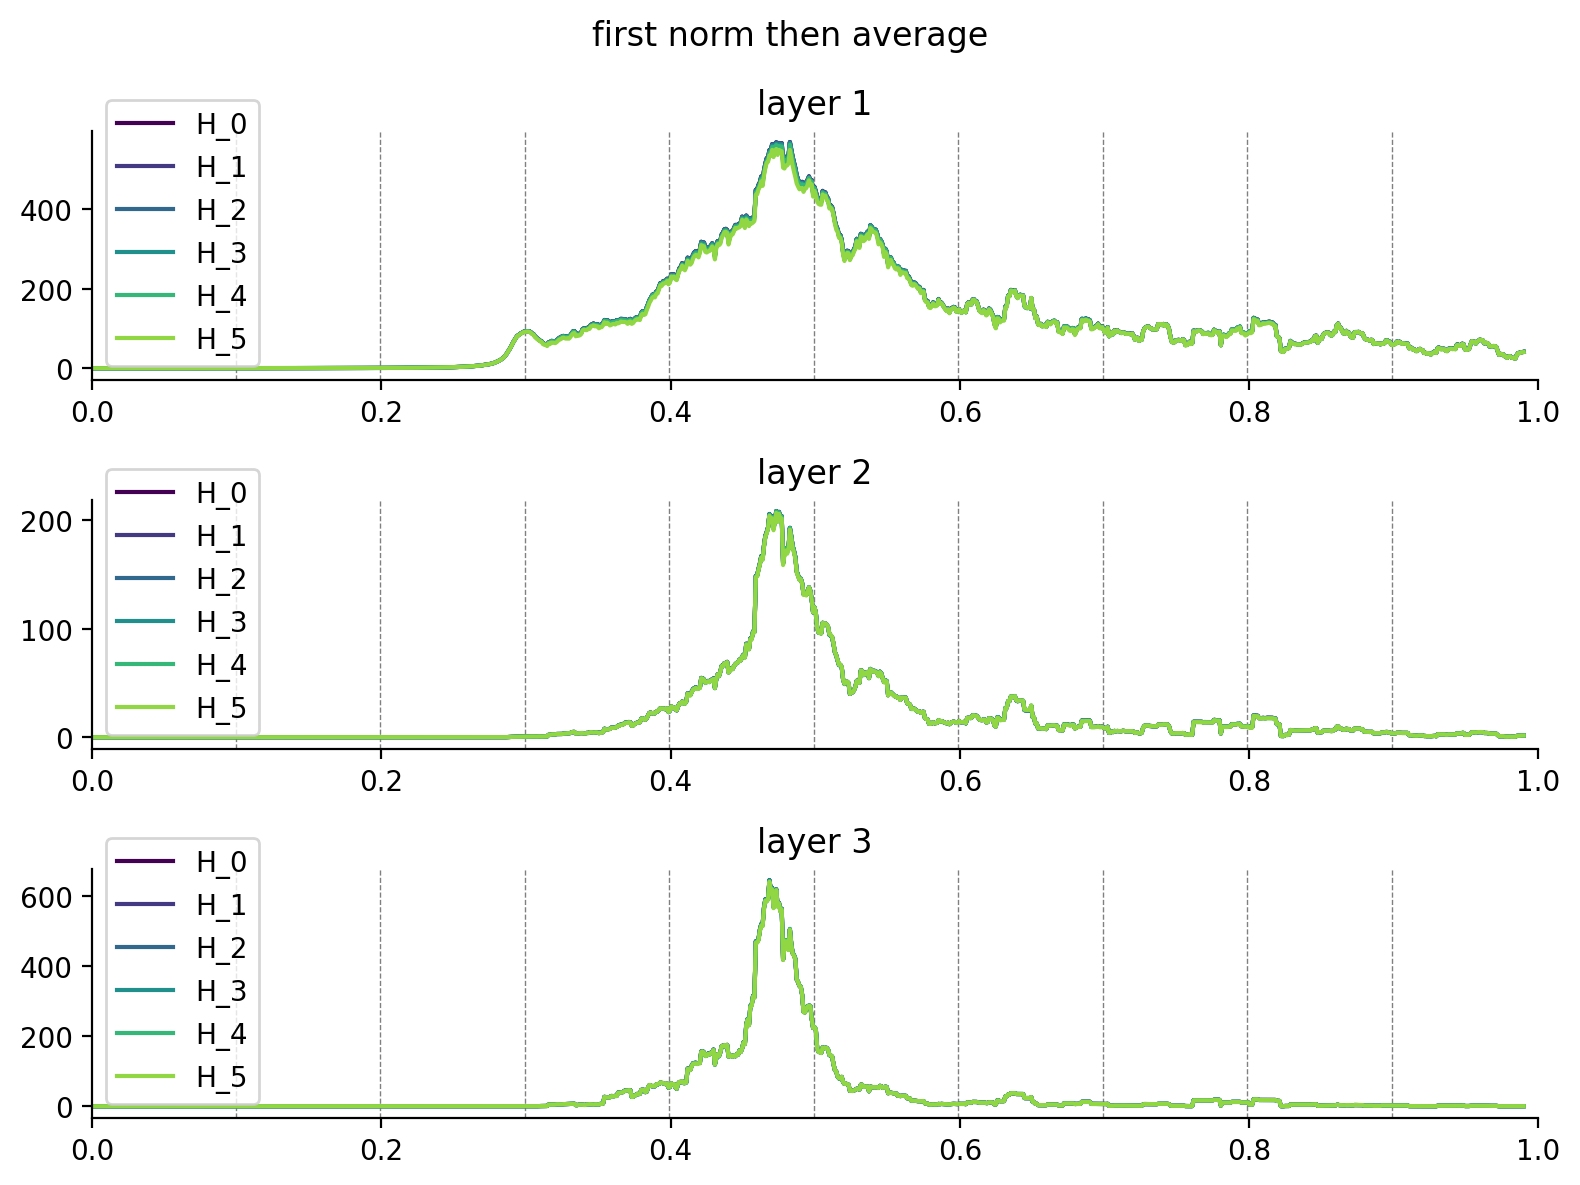

In [27]:
xmin=0
xmax=1
av_window=20
fig=plt.figure(1,figsize=(8,6),dpi=200,frameon=False)
for layer_name, layer_res in layer_gradient_dict.items():
    idx=layer_names.index(layer_name)
    ax1=plt.subplot(3,1,idx+1)
    #ax1=plt.subplot(2,3,1)
    training_l2=np.stack([[np.mean(np.linalg.norm(x,axis=1)) for x in y] for y in  layer_res]).transpose()
    for idy,res in enumerate(training_l2):

        ax1.plot(moving_average(x_bar,av_window),moving_average(res,av_window),label=f"H_{idy}",color=line_cols[idy,:],linewidth=1.5)
    ax1.legend()
    ax1.set_title(f"layer {idx+1}")
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    
    ax1.vlines(epoch_bar,ax1.get_ylim()[0],ax1.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
    ax1.autoscale(enable=True, axis='x', tight=True)
    ax1.autoscale(enable=True, axis='y', tight=True)
    ax1.set_xlim((xmin,xmax))

#ax1=plt.subplot(2,3,(7,8)
plt.suptitle('first norm then average')
plt.tight_layout()

In [29]:

np.linalg.norm(layer_res[1][1],axis=1)

(32,)

In [32]:
training_l2=np.stack([[np.linalg.norm(x.mean(axis=0)) for x in y] for y in  layer_gradient_dict['layer_3_Linear']])

[[<matplotlib.lines.Line2D at 0x2b1e9aa849e8>],

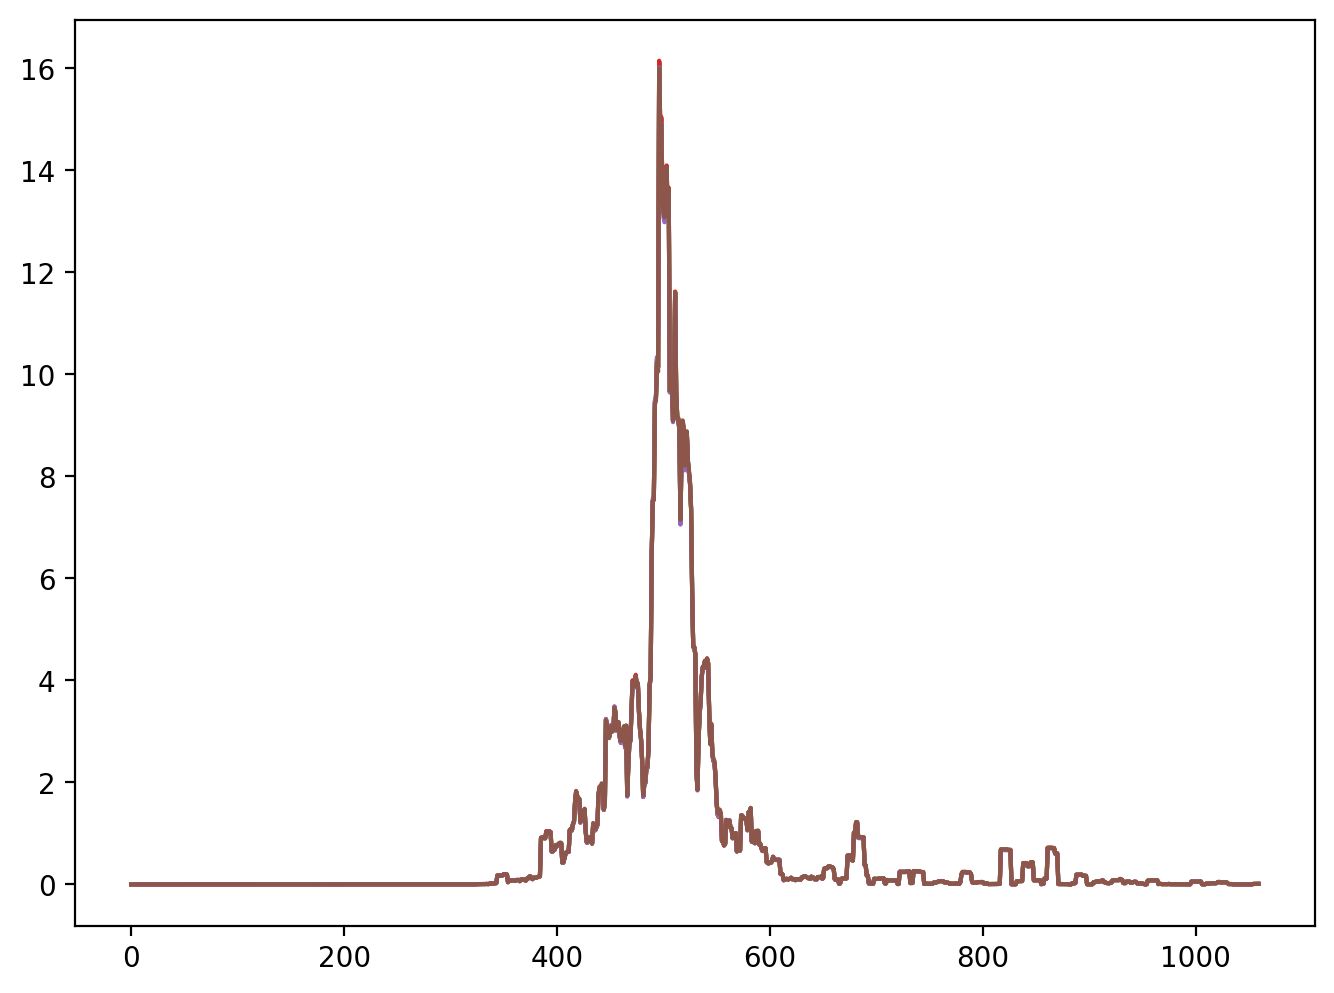

In [41]:
fig=plt.figure(1,figsize=(8,6),dpi=200,frameon=False)

[plt.plot(moving_average(x,av_window)) for x in np.stack(training_l2).transpose()]